In [12]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join, exists

import numpy as np
import matplotlib.pyplot as plt
from h5py import File
import scienceplots

import candel
from candel import plot_corner_from_hdf5, read_samples

from utils import *


%matplotlib inline
%load_ext autoreload
%autoreload 2


COLS = "#1be7ffff", "#6eeb83ff", "#e4ff1aff", "#ffb800ff", "#ff5714ff", "#9b5de5ff",




config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config.toml"
config = candel.load_config(config_path, )
root = join("/Users/rstiskalek/Projects/CANDEL/", "results", "dH0")






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from astropy.coordinates import angular_separation

rootdir = "/Users/rstiskalek/Projects/CANDEL/data/CF4"
RA_virgo = np.deg2rad(candel.hms_to_degrees(12, 27)),
dec_virgo = np.deg2rad(candel.dms_to_degrees(12, 43))
dist_virgo = 16.5 * 0.73  # Mpc/h

k = None
data = {}
reconstructions = ["Carrick2015", "Lilow2024", "CF4"]

for reconstruction in reconstructions:
    with File(join(rootdir, f"los_CF4_TFR_{reconstruction}.hdf5"), 'r') as f:
        if k is None:
            RA = np.deg2rad(f["RA"][...])
            dec = np.deg2rad(f["dec"][...])
            angdist = angular_separation(RA, dec, RA_virgo, dec_virgo)
            k = np.argmin(angdist)

        r = f["r"][...]
        rho = f["los_density"][:, k, :]
        vel = f["los_velocity"][:, k, :]

        if reconstruction == "Carrick2015":
            vel *= 0.43

        data[reconstruction] = [r, rho, vel]
    

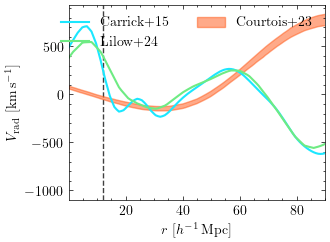

In [26]:
with plt.style.context("science"):
    fig, ax = plt.subplots()
    lw = plt.rcParams["lines.linewidth"]

    for simname in reconstructions:
        r, rho, vel = data[simname]  # vel: (nsamples, nr)
        y = vel

        col = simname2color(simname)
        if vel.shape[0] > 1:
            ylow, yhigh = np.percentile(y, [16, 84], axis=0)
            ax.fill_between(r, ylow, yhigh, alpha=0.5,
                            label=simname2label(simname), color=col)
        else:
            ax.plot(r, y[0], lw=1.5 * lw, label=simname2label(simname),
                    color=col)

    ax.set_xlabel(r"$r~[h^{-1}\,\mathrm{Mpc}]$")
    ax.set_ylabel(r"$V_{\rm rad}~[\mathrm{km}\,\mathrm{s}^{-1}]$")

    ax.set_xlim(r.min(), 90)
    # ax.set_ylim(-800, 1100)

    ax.axvline(dist_virgo, zorder=0, c="k", ls="--", alpha=0.75)

    ax.legend(ncols=2, loc="upper right")

    fig.tight_layout()
    plt.show()